# On Decision Trees

### We use them every day

![tree](img/tree.jpeg)

## Outcomes

- summarize the intuitive logic behind decision trees
- solve a small example with metric
- explore the fine-tuning options in `sklearn` for decision trees
- build a decision tree in `sklearn`


The key tool of decision trees is that some attributes provide more _information_ than others when trying to make a decision.<br>
And we rank attributes in the hierarchy based on how useful they are.

### Example 1 - when looking to monogamously date someone
Which is more important?

Their taste in music?
![music](img/music.png)

Or if they are married already?
![married2](img/married2.png)

### Example 3 with some vocab
Rory is a teenager trying to decide if he wants to go to a party, and this is the decision tree represtinging his process:

#### His decision tree
![party](img/party.png)

( image from this [site](https://chunml.github.io/ChunML.github.io/tutorial/Decision-Tree/) )

### Vocabulary: nodes

![nodes](img/terminology1.png)

### Vocabulary: splits & branches

![split](img/terminology2.png)

### Example 4: with data

Suppose we're working on a classification algorithm designed to **sort customers into two classes: those who pay their sales bills and those who don't**.

Each row in my dataframe represents a customer, and I have many predictors (columns) in my dataframe, including:

- salary
- total_bill
- club_member (boolean)
- years_post-sec_ed

Let's look at a simple set of data. **The 'paid' column is our target or dependent variable.**

In [28]:
import pandas as pd
custs = pd.DataFrame([[45000, 1000, True, 2, False], [70000, 100, True, 10, True],
             [30000, 2000, False, 0, False], [90000, 500, True, 2, True],
             [70000, 200, True, 5, False]],
            columns=['salary', 'total_bill', 'club_member', 'years_post-sec_ed',
                    'paid'])


In [29]:
custs

,salary,total_bill,club_member,years_post-sec_ed,paid
0,45000,1000,True,2,False
1,70000,100,True,10,True
2,30000,2000,False,0,False
3,90000,500,True,2,True
4,70000,200,True,5,False


## Partitioning

I partition my data by asking a question about the independent variables. The goal is to ask the right questions in the right order so that the resultant groups are "pure" with respect to the dependent variable. More on this below!


### Let's explore some variables below:

In [30]:
test = custs.sort_values(['salary'])
test

,salary,total_bill,club_member,years_post-sec_ed,paid
2,30000,2000,False,0,False
0,45000,1000,True,2,False
1,70000,100,True,10,True
4,70000,200,True,5,False
3,90000,500,True,2,True


### Is the customer a club member?

This would divide my data into two groups:

- Group 1:

data points: 0, 1, 3, 4 (dep. var.: False, True, True, False)

- Group 2:

data points: 2 (dep. var.: False)

While I've isolated one of the customers who haven't paid in the second group, the first group is an even mix of payers and non-payers. So this split is not particularly good.

Would a different question split our data more effectively? Let's try:

### "Is the customer's salary less than $60k?"

This would divide my data into two groups:

- Group 1:

data points: 0, 2 (dep. var.: False, False)

-  Group 2:

data points: 1, 3, 4 (dep. var.: True, True, False)

## Which feature is more accurate in predicting whether and individual pays their bill?

This does a better job of partitioning my data according to the values of the dependent variable: The first group contains only customers who have not paid their bills, and the second group contains only one customer who has not paid her bill.

So a (very simple!) model that predicts:
(i) that customers who make less than $60k *won't* pay their bill, and
(ii) that customers who make $60k or more *will* pay their bill

would perform fairly well.

But how would my partition be *best* split? And how do I really know that the second split is better than the first? Can I do better than intuition here?

## Entropy and Information Gain

The goal is to have our ultimate classes be fully "ordered" (for a binary dependent variable, we'd have the 1's in one group and the 0's in the other). So one way to assess the value of a split is to measure how *disordered* our groups are, and there is a notion of *entropy* that measures precisely this.

The entropy of the whole dataset is given by:

$\large E = -\Sigma_i p_i\log_2(p_i)$,

where $p_i$ is the probability of belonging to the $i$th group.

**Entropy will always be between 0 and 1. The closer to 1, the more disordered your group.**

To repeat, in the present case we have only two groups of interest: the payers (2/5) and the non-payers (3/5).

So our entropy for this toy dataset is:

$-0.4*\log_2(0.4) -0.6*\log_2(0.6)$.

Let's use the ```math``` library to calculate this:

In [31]:
from math import log

# Your code here!

ent_whole = -.4*log(.4,2)-0.6*log(.6,2)
ent_whole

0.9709505944546686

That's pretty disordered!

To calculate the entropy of a *split*, we're going to want to calculate the entropy of each of the groups made by the split, and then calculate a weighted average of those groups' entropies––weighted, that is, by the size of the groups. Let's calculate the entropy of the split produced by our question above about salary:

Group 1:

$E_{g1} = 0 * \log_2(0) - 1 * \log_2(1) = 0$. This is a pure group! The probability of being a payer in Group 1 is 0 and the probability of being a non-payer in Group 1 is 1.

Group 2:

$E_{g2} = \frac{2}{3} * \log_2\left(\frac{2}{3}\right) - \frac{1}{3} * \log_2\left(\frac{1}{3}\right)$.

Once again, using ```math```:

In [32]:
# Your code here!

ent_grp2 = -(2/3)*log(2/3,2)-1/3*log(1/3,2)
ent_grp2

0.9182958340544896

To get the whole entropy for this split, we'll do a weighted sum of the two group entropies:

In [33]:
# Your code here!

(2/5)*0 + (3/5)*ent_grp2

0.5509775004326937

For a given split, the **information gain** is simply the entropy of the parent group less the entropy of the split.

For a given parent, then, we maximize our model's performance by *minimizing* the split's entropy.

What we'd like to do then is:

1. to look at the entropies of all possible splits, and
2. to choose the split with the lowest entropy.

In practice there are far too many splits for it to be practical for a person to calculate all these different entropies ...

... but we can make computers do these calculations for us!

## Gini Impurity

An alternative metric to entropy comes from the work of Corrado Gini. The Gini Impurity is defined as:

$\large G = 1 - \Sigma_i p_i^2$,

where, again, $p_i$ is the probability of belonging to the $i$th group.

**Gini Impurity will always be between 0 and 0.5. The closer to 0.5, the more disordered your group.**

Exercise: Calculate the Gini Impurity for our toy dataset above.

In [53]:
# Your code here!

## Coding Trees in Python

Scikit-learn has a tree module, which houses both a DecisionTreeClassifier and a DecisionTreeRegressor. The difference, as is probably clear by now, is that the former is for classification problems (discrete target) and the latter is for regression problems (continuous target). Let's use the classifier.

In [35]:
from sklearn.tree import DecisionTreeClassifier


In [48]:
ct = DecisionTreeClassifier(max_depth=8) # Check out all the
                              # hyperparameter options here!

# dt_mod = ct.fit(custs.drop('paid', axis=1), custs['paid'])
# dt_mod.score(custs.drop('paid', axis=1), custs['paid'])

In [49]:
from sklearn import tree

%matplotlib inline

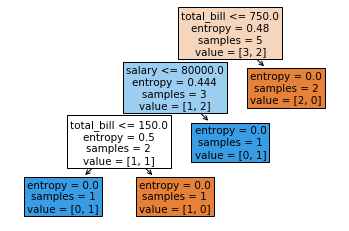

In [54]:
tree.plot_tree(ct.fit(custs.drop('paid', axis=1), custs['paid']),
               feature_names= ['salary', 'total_bill', 'club_member', 'years_post-sec_ed'],
               filled = True );

In [19]:
custs.columns

Index(['salary', 'total_bill', 'club_member', 'years_post-sec_ed', 'paid'], dtype='object')

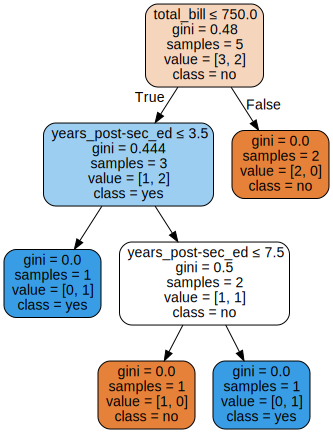

In [52]:
import graphviz 
dot_data = tree.export_graphviz(ct, out_file=None, feature_names= ['salary', 
                                                                   'total_bill', 
                                                                   'club_member',
                                                                   'years_post-sec_ed'],
                     class_names=['no', 'yes'],
                        filled=True, rounded=True,  
                     special_characters=True)  

graph = graphviz.Source(dot_data) 
graph

In [46]:
features = custs.columns.tolist()
features.remove('paid')
features

['salary', 'total_bill', 'club_member', 'years_post-sec_ed']

In [47]:
from sklearn.tree.export import export_text

r = export_text(ct, feature_names= features)
print(r)

|--- total_bill <= 750.00
|   |--- years_post-sec_ed <= 3.50
|   |   |--- class: True
|   |--- years_post-sec_ed >  3.50
|   |   |--- class: False
|--- total_bill >  750.00
|   |--- class: False



In [48]:
dt_mod.tree_.node_count

5

In [49]:
import numpy as np

In [50]:
n_nodes = dt_mod.tree_.node_count
children_left = dt_mod.tree_.children_left
children_right = dt_mod.tree_.children_right
feature = dt_mod.tree_.feature
threshold = dt_mod.tree_.threshold

# This code courtesy of sklearn:
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 5 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 1] <= 750.0 else to node 4.
	node=1 test node: go to node 2 if X[:, 3] <= 3.5 else to node 3.
		node=2 leaf node.
		node=3 leaf node.
	node=4 leaf node.



### Interpretation

Let's unpack this:

The first question ("test") is: "Is Salary $\leq$ 57500?" If so, then stop: All (i.e. both) such customers are *non-payers*.

If not: The next test (for those whose salary > 57500) is: "Is Total Bill $\leq$ 150?" If so, then stop: All such customers (i.e. customer 1) are *payers*. Notice how 150 is midway between the total bills of customer 1 (a payer) and customer 4 (a non-payer).

If not: The next test (for those whose total bill > 150) is: "Is the number of Years of Post-Sec Ed $\leq$ 3.5?" If so, then stop: All such customers (i.e. customer 3) are *payers*. If not, then stop: All such customers (i.e. customer 4) are *non-payers*. Notice how 3.5 is midway between the numbers of years of post-sec ed of customer 3 (a payer) and customer 4 (a non-payer).

In [ ]:
ct = DecisionTreeClassifier()

In [34]:
node_depth

array([0, 1, 2, 2, 3, 3, 1])

In [35]:
stack

[]

In [21]:
ct.tree_.children_left

array([ 1, -1,  3, -1,  5, -1, -1])

In [22]:
ct.tree_.children_right

array([ 2, -1,  4, -1,  6, -1, -1])

### Evaluating a decision tree:
- Train and test - use predict to compare auc of test and train
- "prune" the tree: adjust minimum number of samples required at a leaf node or a split as well as setting the maximum depth of the tree.


### Pros and Cons of Decision Trees

#### Pros:
- Easy to Understand
- Useful in Data exploration
- Less data cleaning required
- Data type is not a constraint
- Non Parametric Method


#### Cons:
- Prone to over-fitting
- Struggles with creating cut-off splits with continuous variables


## Outcome Review

- summarize the intuitive logic behind decision trees
- solve a small example with metric
- explore the fine-tuning options in `sklearn` for decision trees
- build a decision tree in `sklearn`
